In [2]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import matplotlib.colors

# Task 1: Compare the timings of forloops, np and torch broadcasts

In [3]:
def for_loop_normie(X_mat, T_mat):
    # X_mat: X matrix
    # T_mat: T matrix
    
    X_ins_size = X_mat.shape[0]
    T_ins_size = T_mat.shape[0]
    
    # Main euclidean matrix containing all the pairwise euclidean distances in the shape of N x D
    euclidean_mat = np.zeros((X_ins_size, T_ins_size))
    
    for i in range(X_ins_size):
        # This array will be fitted into the main euclidean matrix
        sub_euc_mat = np.zeros((1, T_ins_size))
        
        for j in range(T_ins_size):
            xi = X_mat[i,:]
            tj = T_mat[j,:]
            
            e_dist = np.dot(xi, xi) - (2 * (np.dot(xi, tj))) + np.dot(tj,tj)
            sub_euc_mat[:, j] = e_dist
    
        euclidean_mat[i,:] = sub_euc_mat
        
    return euclidean_mat

In [4]:
def numpy_style(X_mat, T_mat):
    # X_mat: X matrix
    # T_mat: T matrix
    
    # Use np.newaxis to insert 1 into the matrix to make it into the shape N x 1 x D
    bcast_X = X_mat[:,np.newaxis,:]
    # Get the difference between the broadcasted X and T, where the latter has shape P x D
    XT_diff = bcast_X - T_mat # broadcasting happens here and we get N x P x D shape
    # Square
    sq_diff = np.square(XT_diff)
    # Sum in the D axisa so that our resulting matrix is of shape N x P
    XT_sum = np.sum(sq_diff, axis=2)
    
    return XT_sum

In [5]:
def human_torch(X_mat, T_mat):
    # X_mat: X tensor
    # T_mat: T tensor
    
    # Use torch.unsqueeze to insert 1 into the matrix to make it into shape N x 1 x D
    unsqueeze_X = torch.unsqueeze(X_mat, axis=1)
    # Get the difference between the broadcasted X and T, where the latter has shape P x D
    XT_diff = unsqueeze_X - T_mat # broadcasting happens here and we get N x P x D shape
    # Square
    sq_diff = torch.mul(XT_diff, XT_diff)
    # Sum
    XT_sum = torch.sum(sq_diff, axis=2)
    
    return XT_sum

## Testing start

In [6]:
# Set up the matrices and tensors for testing
np.random.seed(128)
X = np.random.random((4000,300))
T = np.random.random((100,300))

X_tensor = torch.from_numpy(X)
T_tensor = torch.from_numpy(T)

In [7]:
# Test with for loop
start_time = time.time()
for_loop_normie(X,T)
print(f'for loop mode time taken = {time.time() - start_time} seconds')

for loop mode time taken = 1.9560456275939941 seconds


In [8]:
# Test with numpy broadcasting
start_time = time.time()
numpy_style(X,T)
print(f'numpy mode time taken = {time.time() - start_time} seconds')

numpy mode time taken = 1.0338020324707031 seconds


In [9]:
# Test with Torch broadcasting
start_time = time.time()
human_torch(X_tensor, T_tensor)
print(f'torch mode time taken = {time.time() - start_time} seconds')

torch mode time taken = 0.4668600559234619 seconds


In [12]:
# Test with Torch broadcasting gpu version

# Uncomment below only if you want to use gpu
# X_cuda = (torch.from_numpy(X)).cuda()
# T_cuda = (torch.from_numpy(T)).cuda()

# start_time = time.time()
# human_torch(X_cuda, T_cuda)
# print(f'torch gpu mode time taken = {time.time() - start_time} seconds')
# torch.cuda.memory_allocated()

torch gpu mode time taken = 0.0009965896606445312 seconds


## From the above we can see that amongst forloops, numpy and torch broadcasting methods, torch CPU method did the best in terms of calculating the distance matrix. On a side note, after caching the copied data from CPU over to GPU, the performance was about 17 times faster than torch cpu.

# Task 2: Kmeans Algorithm

In [14]:
def prep_data(blobs, dpoints, clusters, features):
    # blobs: num of gaussian blobs, dpoints: num of datapoints
    # clusters: total clusters, features: total features
    
    # Dataset of shape (blobs*dpoints) x features
    dataset = torch.cat([torch.empty(dpoints, features).normal_(mean=x,std=0.3,generator=torch.manual_seed(x)) for x in range(blobs)])
    
    # Cluster centroids chosen from dataset of shape clusters x features
    c_centroids = (torch.cat([dataset[i] for i in range(clusters)])).view((clusters,features))
    
    return dataset, c_centroids
    

In [15]:
def kmeans_leggo(dataset, centroids, M_limit):
    # dataset: your dataset, centroids: starting centroids, M_limit: epochs
    datapoints = dataset
    current_centroids = centroids
    
    # To track previous centroids
    previous_centroids = torch.zeros_like(current_centroids)

    # Checker, this checks if there was any change in centroids. If no change, kmeans terminates
    checker = torch.dist(current_centroids, previous_centroids)

    # Iterations
    iterations = 0
    
    # Threshold used = 0
    while checker > 0:
        iterations += 1
        ### Get our euclidean matrix using the function from Task 1 ###
        euclidean_matrix = human_torch(datapoints, current_centroids) # N x P matrix

        # We take the argmin of each row to find the index of the cluster that the datapoint belongs to, and store it
        # in a cluster map with shape N x 1
        cluster_map = torch.argmin(euclidean_matrix, axis=1)

        ### Get the new centroid ###
        new_centroids = torch.zeros_like(current_centroids)

        # Iterate through each cluster
        for cluster_index in range(centroids.shape[0]):
            # We use the cluster map to get the indexes of the datapoints that belong to this certain cluster
            # Returns True or False in the tensor
            cluster_dpoint_indexes = cluster_map == cluster_index

            # Get the mean of the gathered datapoints to determine the new centroid
            new_centroid = torch.mean(datapoints[cluster_dpoint_indexes], axis=0)
            new_centroids[cluster_index, :] = new_centroid

        # Update previous and current centroids
        previous_centroids = current_centroids
        current_centroids = new_centroids

        checker = torch.dist(current_centroids, previous_centroids) # check

        print('checker', checker)
        print("iteration number: " + str(iterations))
        print("new centroids: ")
        print(current_centroids)

        # break the while loop if M limit is hit
        if iterations == M_limit:
            break
            
    return current_centroids, cluster_map


In [16]:
def clusters_plot(dataset, cluster_map, s_centroids, f_centroids):
    # dataset: your dataset 
    # cluster_map: cluster map containing latest indexes of each datapoint to their respective clusters
    # s_centroids: starting centroids, f_centroids: final centroids
    
    # Plot the datapoints final position 
    fig, ax = plt.subplots()
    colors1 = ['blue','brown','yellow','cyan', 'orange', 'pink', 'purple', 'green']
    ax.scatter(dataset[:, 0], dataset[:, 1], c=cluster_map, cmap=matplotlib.colors.ListedColormap(colors1))
    
    # PLot the initial starting positions of centroids
    colors2 = ['red']
    ax.scatter(s_centroids[:, 0], s_centroids[:, 1], c=colors2, label='starting centroids', cmap=matplotlib.colors.ListedColormap(colors2))
    
    # Plot the final positions of centroids
    colors3 = ['black']
    ax.scatter(f_centroids[:, 0], f_centroids[:, 1], c=colors3, label='final centroids', cmap=matplotlib.colors.ListedColormap(colors3))
    
    ax.legend()
    plt.show()

In [17]:
# Run kmeans and plot together
def shortcut(b, dp, c, f, m):
    # b: blobs, dp: datapoints, c: clusters, f: features, m: M limit
    
    # Initialize dataset and centroids -> eg 5 blobs, 50 datapoints each, 5 clusters, 2 features
    dset, starter_centroids = prep_data(b, dp, c, f)
    # Run kmeans to get updated centroids and cluster map
    updated_centroids, latest_cluster_map = kmeans_leggo(dset, starter_centroids, m)
    # Plot it out
    clusters_plot(dset, latest_cluster_map, starter_centroids, updated_centroids)
    
    return ('Success')
    

## Testing start (ps scroll down for the plot)

### Cluster P = 2

checker tensor(3.0697)
iteration number: 1
new centroids: 
tensor([[-0.4302, -0.4299],
        [ 2.0444,  2.0868]])
checker tensor(1.1084)
iteration number: 2
new centroids: 
tensor([[0.0908, 0.1731],
        [2.5965, 2.6242]])
checker tensor(0.7256)
iteration number: 3
new centroids: 
tensor([[0.4536, 0.4765],
        [2.9726, 3.0259]])
checker tensor(0.1039)
iteration number: 4
new centroids: 
tensor([[0.5075, 0.5368],
        [3.0205, 3.0702]])
checker tensor(0.0414)
iteration number: 5
new centroids: 
tensor([[0.5306, 0.5597],
        [3.0384, 3.0885]])
checker tensor(0.0210)
iteration number: 6
new centroids: 
tensor([[0.5407, 0.5731],
        [3.0484, 3.0962]])
checker tensor(0.)
iteration number: 7
new centroids: 
tensor([[0.5407, 0.5731],
        [3.0484, 3.0962]])


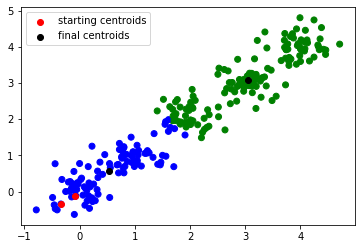

'Success'

In [18]:
shortcut(5,50,2,2,20)

### Cluster P = 5

checker tensor(2.9188)
iteration number: 1
new centroids: 
tensor([[-0.4861, -0.3958],
        [-0.1148,  0.0523],
        [ 2.2617,  2.3091],
        [-0.0948, -0.6346],
        [ 0.1928, -0.3020]])
checker tensor(1.2385)
iteration number: 2
new centroids: 
tensor([[-0.4861, -0.3958],
        [ 0.3935,  0.5732],
        [ 2.8703,  2.9030],
        [-0.0948, -0.6346],
        [ 0.5540,  0.0862]])
checker tensor(0.6887)
iteration number: 3
new centroids: 
tensor([[-0.2791, -0.1354],
        [ 0.7307,  0.8313],
        [ 2.9927,  3.0445],
        [ 0.0797, -0.4349],
        [ 0.2826,  0.0195]])
checker tensor(0.5574)
iteration number: 4
new centroids: 
tensor([[-0.2516, -0.0226],
        [ 1.0991,  1.1420],
        [ 3.1333,  3.1751],
        [ 0.1106, -0.4035],
        [ 0.1529,  0.1167]])
checker tensor(0.5089)
iteration number: 5
new centroids: 
tensor([[-0.2611, -0.0263],
        [ 1.3683,  1.4095],
        [ 3.3418,  3.3700],
        [ 0.1517, -0.3495],
        [ 0.1934,  0.2815]])


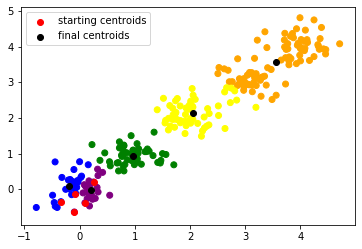

'Success'

In [19]:
shortcut(5,50,5,2,20)

### Cluster P = 8

checker tensor(3.3900)
iteration number: 1
new centroids: 
tensor([[-0.4861, -0.3958],
        [-0.1167, -0.0227],
        [ 2.5441,  2.5317],
        [-0.0948, -0.6346],
        [ 0.1620, -0.3458],
        [ 0.0522,  0.1048],
        [ 0.5273,  1.1185],
        [ 0.3116, -0.1223]])
checker tensor(0.8414)
iteration number: 2
new centroids: 
tensor([[-0.4861, -0.3958],
        [-0.1293,  0.0363],
        [ 2.9927,  3.0445],
        [-0.0948, -0.6346],
        [ 0.1620, -0.3458],
        [ 0.0623,  0.3044],
        [ 0.9433,  0.9535],
        [ 0.3116, -0.1223]])
checker tensor(0.4865)
iteration number: 3
new centroids: 
tensor([[-0.4861, -0.3958],
        [-0.1296,  0.0488],
        [ 3.1899,  3.2337],
        [-0.0948, -0.6346],
        [ 0.1620, -0.3458],
        [ 0.0712,  0.3716],
        [ 1.2183,  1.2371],
        [ 0.2859, -0.1000]])
checker tensor(0.5517)
iteration number: 4
new centroids: 
tensor([[-0.4861, -0.3958],
        [-0.1119,  0.0854],
        [ 3.4095,  3.4342],
     

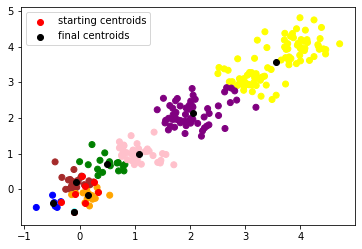

'Success'

In [20]:
shortcut(5,50,8,2,20)